# SETUP & IMPORT EVERYTHING

In [2]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('it4').getOrCreate()

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler,VectorIndexer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import col, udf,when,isnan,count,isnull

# READ

In [4]:
df = spark.read.csv('aws-instance/Datasets/dtd.csv', header=True, inferSchema=True)

# TRANSFORM ATTRITION

In [97]:
def get_attrition(attrition):
  if attrition=="Yes":
    attrition=1
  else:
    attrition=0
  return attrition

udf_attrition = udf(lambda attrition : get_attrition(attrition),IntegerType())
master_df=df.withColumn("attrition_class", udf_attrition(df.Attrition)).drop("Attrition")
#master_df.show()
#master_df.groupby("attrition_class").count().show()

In [27]:
df

DataFrame[Age: int, Attrition: string, BusinessTravel: string, DailyRate: int, Department: string, DistanceFromHome: int, Education: int, EducationField: string, EmployeeCount: int, EmployeeNumber: int, EnvironmentSatisfaction: int, Gender: string, HourlyRate: int, JobInvolvement: int, JobLevel: int, JobRole: string, JobSatisfaction: int, MaritalStatus: string, MonthlyIncome: int, MonthlyRate: int, NumCompaniesWorked: int, Over18: string, OverTime: string, PercentSalaryHike: int, PerformanceRating: int, RelationshipSatisfaction: int, StandardHours: int, StockOptionLevel: int, TotalWorkingYears: int, TrainingTimesLastYear: int, WorkLifeBalance: int, YearsAtCompany: int, YearsInCurrentRole: int, YearsSinceLastPromotion: int, YearsWithCurrManager: int]

In [28]:
master_df

DataFrame[Age: int, BusinessTravel: string, DailyRate: int, Department: string, DistanceFromHome: int, Education: int, EducationField: string, EmployeeCount: int, EmployeeNumber: int, EnvironmentSatisfaction: int, Gender: string, HourlyRate: int, JobInvolvement: int, JobLevel: int, JobRole: string, JobSatisfaction: int, MaritalStatus: string, MonthlyIncome: int, MonthlyRate: int, NumCompaniesWorked: int, Over18: string, OverTime: string, PercentSalaryHike: int, PerformanceRating: int, RelationshipSatisfaction: int, StandardHours: int, StockOptionLevel: int, TotalWorkingYears: int, TrainingTimesLastYear: int, WorkLifeBalance: int, YearsAtCompany: int, YearsInCurrentRole: int, YearsSinceLastPromotion: int, YearsWithCurrManager: int, attrition_class: int]

# INDEXERS & ENCODERS → DF

In [98]:
categoricalCols=["BusinessTravel","Department","EducationField","Gender","JobRole","MaritalStatus",\

        "OverTime"]

continuousCols=["Age",'DailyRate','DistanceFromHome',\

'Education','EmployeeCount',\

'EnvironmentSatisfaction','HourlyRate',\

'JobInvolvement','JobLevel','JobSatisfaction',\

'MonthlyIncome','MonthlyRate','NumCompaniesWorked',\

'PercentSalaryHike','PerformanceRating','RelationshipSatisfaction',\

'StandardHours','StockOptionLevel','TotalWorkingYears',\

'TrainingTimesLastYear','WorkLifeBalance',\

'YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']

In [99]:
indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
         for c in categoricalCols ]

encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
         outputCol="{0}_encoded".format(indexer.getOutputCol()))
         for indexer in indexers ]

In [100]:
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders] + continuousCols, outputCol="features")

In [101]:
pipeline = Pipeline(stages=indexers + encoders + [assembler])

In [104]:
model=pipeline.fit(master_df)

IllegalArgumentException: 'requirement failed: Output column BusinessTravel_indexed already exists.'

In [103]:
master_df = model.transform(master_df)

In [19]:
master_df.columns

['Age',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeCount',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'Over18',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'attrition_class',
 'BusinessTravel_indexed',
 'Department_indexed',
 'EducationField_indexed',
 'Gender_indexed',
 'JobRole_indexed',
 'MaritalStatus_indexed',
 'OverTime_indexed',
 'BusinessTravel_indexed_encoded',
 'Department_indexed_encoded',
 'EducationField_indexed_encoded',
 'Gender_indexed_encoded',
 'JobRole_indexed_encoded',
 'MaritalStatus_indexe

In [25]:
master_df.select('features').collect()

[Row(features=DenseVector([0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 49.0, 279.0, 8.0, 1.0, 1.0, 3.0, 61.0, 2.0, 2.0, 2.0, 5130.0, 24907.0, 1.0, 23.0, 4.0, 4.0, 80.0, 1.0, 10.0, 3.0, 3.0, 10.0, 7.0, 1.0, 7.0])),
 Row(features=SparseVector(46, {0: 1.0, 2: 1.0, 8: 1.0, 9: 1.0, 12: 1.0, 19: 1.0, 21: 37.0, 22: 1373.0, 23: 2.0, 24: 2.0, 25: 1.0, 26: 4.0, 27: 92.0, 28: 2.0, 29: 1.0, 30: 3.0, 31: 2090.0, 32: 2396.0, 33: 6.0, 34: 15.0, 35: 3.0, 36: 2.0, 37: 80.0, 39: 7.0, 40: 3.0, 41: 3.0})),
 Row(features=SparseVector(46, {1: 1.0, 2: 1.0, 4: 1.0, 11: 1.0, 18: 1.0, 21: 33.0, 22: 1392.0, 23: 3.0, 24: 4.0, 25: 1.0, 26: 4.0, 27: 56.0, 28: 3.0, 29: 1.0, 30: 3.0, 31: 2909.0, 32: 23159.0, 33: 1.0, 34: 11.0, 35: 3.0, 36: 3.0, 37: 80.0, 39: 8.0, 40: 3.0, 41: 3.0, 42: 8.0, 43: 7.0, 44: 3.0})),
 Row(features=DenseVector([0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 32.0, 1005.0, 2.0

# SPLIT

In [105]:
splits = master_df.randomSplit([0.9, 0.1])
train_df = splits[0]
test_df = splits[1]

In [61]:
train_df.columns

['Age',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeCount',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'Over18',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'attrition_class',
 'BusinessTravel_indexed',
 'Department_indexed',
 'EducationField_indexed',
 'Gender_indexed',
 'JobRole_indexed',
 'MaritalStatus_indexed',
 'OverTime_indexed',
 'BusinessTravel_indexed_encoded',
 'Department_indexed_encoded',
 'EducationField_indexed_encoded',
 'Gender_indexed_encoded',
 'JobRole_indexed_encoded',
 'MaritalStatus_indexe

# PCA

In [53]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors


pca = PCA(k=5, inputCol="features", outputCol="pcaFeatures")
modelpca = pca.fit(master_df)

In [54]:
pcaresult = modelpca.transform(master_df).select("pcaFeatures","attrition_class")
pcaresult.show(truncate=False)

+--------------------------------------------------------------------------------------------------+---------------+
|pcaFeatures                                                                                       |attrition_class|
+--------------------------------------------------------------------------------------------------+---------------+
|[25088.96075161403,4146.596703550005,-322.0133946095672,62.98474387812009,-41.31392851481371]     |0              |
|[2473.827618927351,1995.2217075684234,-1376.1323236119892,91.40550399005504,-29.900412225203695]  |1              |
|[23252.905570082152,1996.9071162284372,-1433.2755104119994,56.25771465326511,-28.90889054634907]  |0              |
|[11973.63081962452,2599.7688884035842,-1025.1077544413497,79.11154904795029,-27.679210995378373]  |0              |
|[10058.864273866926,2277.079786183098,-1340.8494109962064,81.27760551454801,-50.11459287090052]   |0              |
|[13428.091087351824,2167.449584577951,-1381.1045063527986,67.09

# SPLIT PCA

In [80]:
splitspca = pcaresult.randomSplit([0.9, 0.1])
pcatrain_df = splitspca[0]
pcatest_df = splitspca[1]

In [81]:
print((pcatrain_df.count(), len(pcatrain_df.columns)))

(1316, 2)


In [82]:
print((pcatest_df.count(), len(pcatest_df.columns)))

(146, 2)


# LR

In [83]:
from pyspark.ml.classification import LogisticRegression

logr = LogisticRegression(maxIter = 1,featuresCol = 'pcaFeatures', labelCol="attrition_class")

#lr = LinearRegression()
logr_model = logr.fit(pcatrain_df)
# Make predictions.
lgpredictions = logr_model.transform(pcatest_df)
lgpredictions_train = logr_model.transform(pcatrain_df)

In [86]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="attrition_class", predictionCol="prediction", metricName="accuracy")
lgaccuracy = evaluator.evaluate(lgpredictions)
lgaccuracy_train = evaluator.evaluate(lgpredictions_train)
print("Test Accuracy = %g" % (lgaccuracy))
print("Train Accuracy = %g" % (lgaccuracy_train))
predictions_and_labels = logr_model.evaluate(pcatest_df)
evaluatorroc = BinaryClassificationEvaluator(labelCol="attrition_class")
my_final_roc = evaluatorroc.evaluate(predictions_and_labels.predictions)
print("AUC Score =",my_final_roc)

Test Accuracy = 0.842466
Train Accuracy = 0.840426
AUC Score = 0.6320254506892895


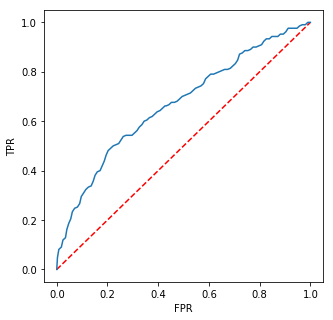

In [85]:
#ROC
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(logr_model.summary.roc.select('FPR').collect(),
         logr_model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [115]:
lgpredictions.select("pcaFeatures","attrition_class","prediction").show(1000)

+--------------------+---------------+----------+
|         pcaFeatures|attrition_class|prediction|
+--------------------+---------------+----------+
|[2440.60780308777...|              0|       0.0|
|[2854.21935728355...|              0|       0.0|
|[2866.32079049695...|              0|       0.0|
|[3216.08054821800...|              0|       0.0|
|[3243.86010553330...|              0|       0.0|
|[3454.50501053859...|              1|       0.0|
|[3943.26121788038...|              0|       0.0|
|[4104.53788655422...|              0|       0.0|
|[4384.88461390587...|              0|       0.0|
|[4437.77516680057...|              0|       0.0|
|[4494.42011763553...|              0|       0.0|
|[4612.66590454888...|              0|       0.0|
|[4854.52476001905...|              1|       0.0|
|[5624.86145979332...|              0|       0.0|
|[5684.70143402303...|              0|       0.0|
|[5796.31748502548...|              0|       0.0|
|[5869.84536735443...|              0|       0.0|


In [58]:
from pyspark.ml.classification import LogisticRegression

maxIters = [1,10,100,200]

for i in maxIters:
    logr = LogisticRegression(maxIter = i, featuresCol = 'pcaFeatures', labelCol="attrition_class")
    logr_model1 = logr.fit(pcatrain_df)
    lgpredictions = logr_model1.transform(pcatest_df)
    lgpredictions_train = logr_model1.transform(pcatrain_df)
    evaluator = MulticlassClassificationEvaluator(labelCol="attrition_class", predictionCol="prediction", metricName="accuracy")
    lgaccuracy = evaluator.evaluate(lgpredictions)
    lgaccuracy_train = evaluator.evaluate(lgpredictions_train)
    print(i,":Train Accuracy = %g" % (lgaccuracy_train))
    evaluatorroc = BinaryClassificationEvaluator(labelCol="attrition_class")
    my_final_roc = evaluatorroc.evaluate(predictions_and_labels.predictions)
    print(i,":AUC Score=",my_final_roc)

1 :Train Accuracy = 0.836656
1 :AUC Score= 0.5909090909090908
10 :Train Accuracy = 0.836656
10 :AUC Score= 0.5909090909090906
100 :Train Accuracy = 0.836656
100 :AUC Score= 0.5909090909090908
200 :Train Accuracy = 0.836656
200 :AUC Score= 0.5909090909090908


# EVALUATION

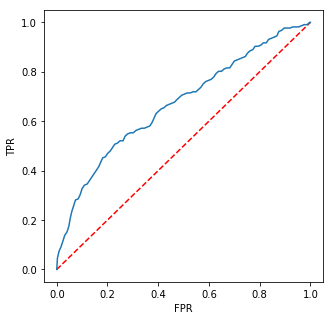

In [62]:
#ROC
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(logr_model.summary.roc.select('FPR').collect(),
         logr_model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [26]:
# And evaluating it against the test data.
predictions_and_labels = logr_model.evaluate(pcatest_df)

predictions_and_labels.predictions.show()

+--------------------+---------------+--------------------+--------------------+----------+
|         pcaFeatures|attrition_class|       rawPrediction|         probability|prediction|
+--------------------+---------------+--------------------+--------------------+----------+
|[2473.82761892735...|              1|[1.50016623618910...|[0.81759926842255...|       0.0|
|[2961.08445514393...|              0|[1.70747563621379...|[0.84650857591208...|       0.0|
|[3106.35872888123...|              1|[1.07348072691282...|[0.74525829009460...|       0.0|
|[4321.27472403401...|              0|[1.45903051657147...|[0.81138435003739...|       0.0|
|[4365.55533184512...|              0|[1.35747889551294...|[0.79534964664703...|       0.0|
|[4619.88118211139...|              0|[3.62379447420369...|[0.97401214537827...|       0.0|
|[4903.74305027891...|              0|[2.90161997595378...|[0.94792646004025...|       0.0|
|[4975.19988990786...|              0|[1.30820270271031...|[0.78721224759300...|

In [70]:
#AUC Score
# Let's import two evalulation metrics. 
# Remember, binary is for predictions like true and false (0 and 1), 
# While multi-class is for multiple classification classes.
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator

# According to this evaluation metric, the area under the curve is 1.0. A perfect fit? Is that realistic?  
evaluator = BinaryClassificationEvaluator(labelCol="attrition_class")
my_final_roc = evaluator.evaluate(predictions_and_labels.predictions)
my_final_roc

0.7744107744107744

# Drop rows with missing values

In [90]:
df1 = spark.read.csv('aws-instance/Datasets/dtd.csv', header=True, inferSchema=True)

In [19]:
df1.show(4)

+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalanc

In [20]:
df1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df1.columns]).show()

+---+---------+--------------+---------+----------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+-------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPr

In [91]:
df2 = spark.read.csv('aws-instance/Datasets/dtd2.csv', header=True, inferSchema=True)

In [21]:
import pyspark.sql.functions as f
from functools import reduce
df1.where(reduce(lambda x, y: x | y, (f.col(x).isNull() for x in df1.columns))).count()

8

In [92]:
print((df1.count(), len(df1.columns)))

(988, 35)


In [93]:
# Using this syntax, we can drop any row with missing data. Three rows are dropped.
df1=df1.na.drop()

In [94]:
print((df1.count(), len(df1.columns)))

(980, 35)


In [95]:
print((df2.count(), len(df2.columns)))

(482, 35)


# Join

In [96]:
df = df1.union(df2)

In [10]:
df.collect()

[Row(Age=49, Attrition='No', BusinessTravel='Travel_Frequently', DailyRate=279, Department='Research & Development', DistanceFromHome=8, Education=1, EducationField='Life Sciences', EmployeeCount=1, EmployeeNumber=2, EnvironmentSatisfaction=3, Gender='Male', HourlyRate=61, JobInvolvement=2, JobLevel=2, JobRole='Research Scientist', JobSatisfaction=2, MaritalStatus='Married', MonthlyIncome=5130, MonthlyRate=24907, NumCompaniesWorked=1, Over18='Y', OverTime='No', PercentSalaryHike=23, PerformanceRating=4, RelationshipSatisfaction=4, StandardHours=80, StockOptionLevel=1, TotalWorkingYears=10, TrainingTimesLastYear=3, WorkLifeBalance=3, YearsAtCompany=10, YearsInCurrentRole=7, YearsSinceLastPromotion=1, YearsWithCurrManager=7),
 Row(Age=37, Attrition='Yes', BusinessTravel='Travel_Rarely', DailyRate=1373, Department='Research & Development', DistanceFromHome=2, Education=2, EducationField='Other', EmployeeCount=1, EmployeeNumber=4, EnvironmentSatisfaction=4, Gender='Male', HourlyRate=92, Jo

In [11]:
print((df.count(), len(df.columns)))

(1462, 35)


In [34]:
print((master_df.count(), len(master_df.columns)))

(1462, 50)
